# Collaboration and Competition

### *1. Import Packages and Start the Environment

In [2]:
import sys
import random, copy, time
from collections import namedtuple, deque
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
%matplotlib inline



In [3]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# step 3. Examine the State and Action Spaces¶

Run the code cell below to print some information about the environment.

In [5]:

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


# Step 4. Take Random Actions in the Environment


In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


# 4. It's Your Turn!

In [1]:
BUFFER_SIZE = int(1e6)     # replay buffer size
BATCH_SIZE = 128           # minibatch size
GAMMA = 0.99               # discount factor
TAU = 1e-3                 # for soft update of target parameters
SEED = 3                   # random seed
LR_ACTOR = 1e-4            # learning rate of the actor 
LR_CRITIC = 1e-3           # l earning rate of the critic
WEIGHT_DECAY = 0           # L2 weight decay
SIGMA = 0.1                # standard deviation for noise

#### Solving environment Using Multi-Agent Decentralized-Actor Centralized-Critic Algorithm

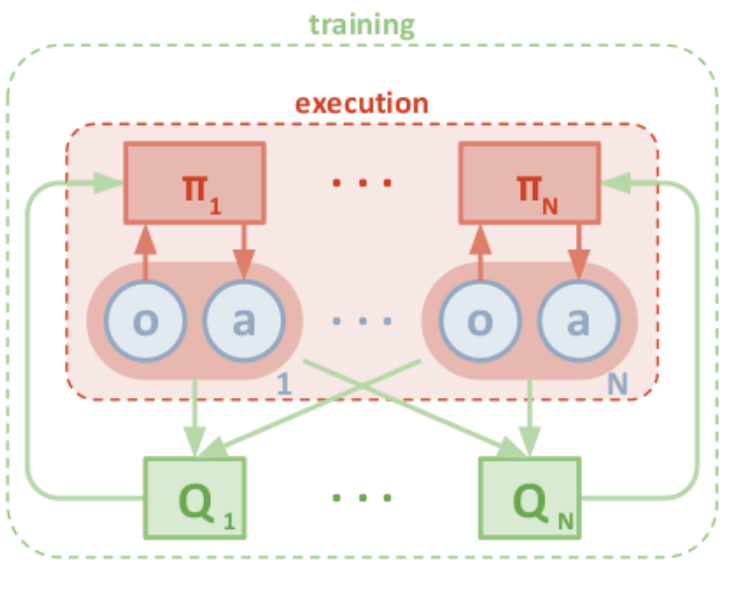

# Actor Class

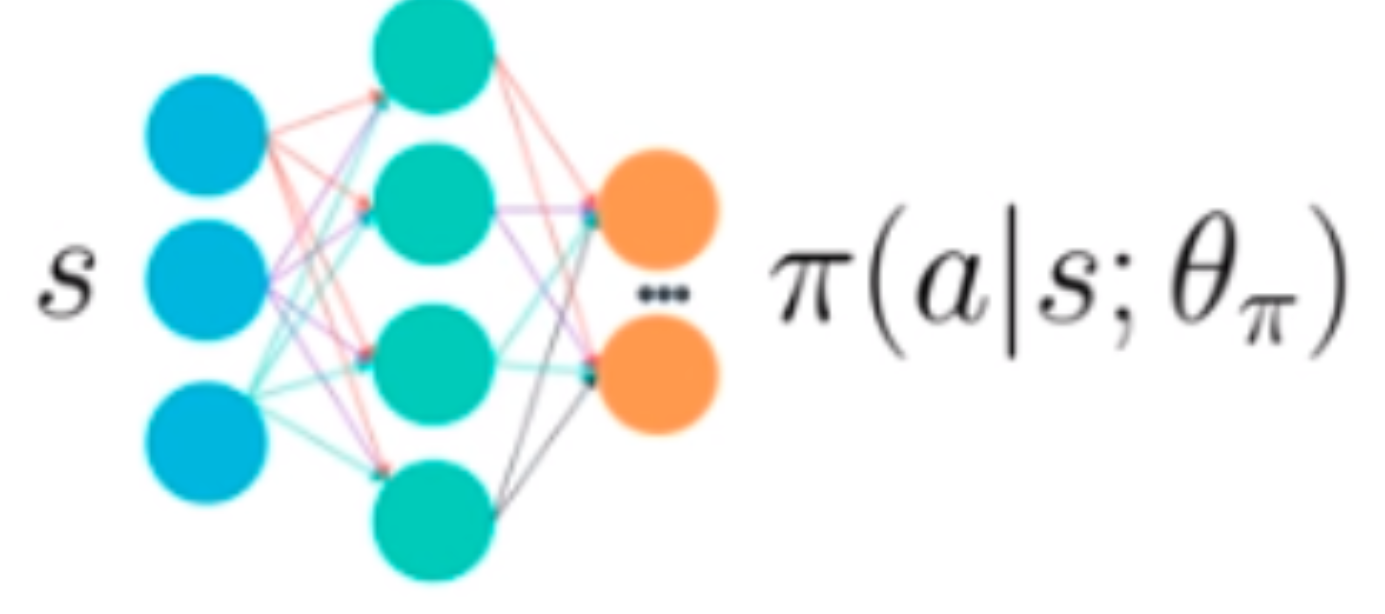

In [48]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, num_agents, state_size, action_size, seed, 
                 fc1_units=512, fc2_units=256, fc3_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
            fc2_units (int): Number of nodes in third hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, action_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_normal_(self.fc1.weight.data, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.fc2.weight.data, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.fc3.weight.data, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.fc4.weight.data, nn.init.calculate_gain('tanh'))
    

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = self.bn1(self.fc1(state)).relu()
        x = self.fc2(x).relu()
        x = self.fc3(x).relu()
        return self.fc4(x).tanh()

# Class Critic

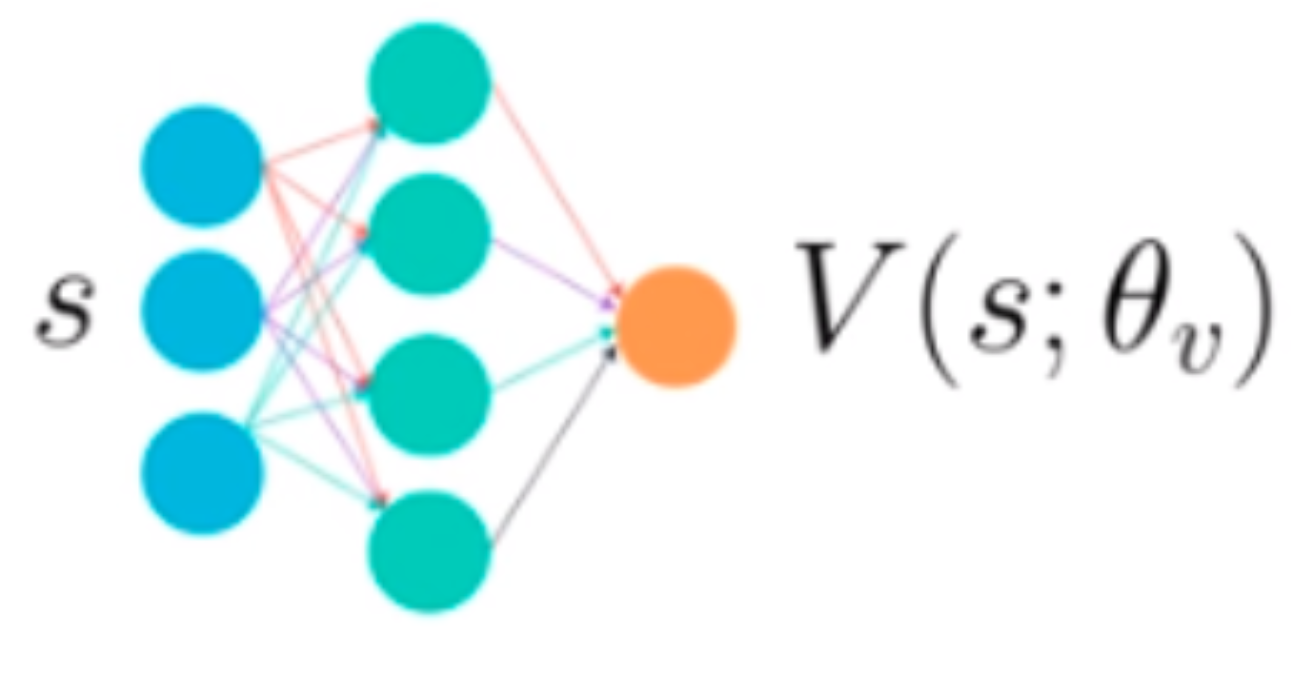

In [59]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, num_agents, state_size, action_size, seed, 
                 fc1_units=512, fc2_units=256, fc3_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
            fc3_units (int): Number of nodes in the third hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        # layers
        self.fc1 = nn.Linear(num_agents*state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units+(num_agents*action_size), fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        # weight initialization
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_normal_(self.fc1.weight.data, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.fc2.weight.data, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.fc3.weight.data, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.fc4.weight.data, nn.init.calculate_gain('linear'))
        

    def forward(self, state, action):
        """Build a critic (value) network that maps (
           state, action) pairs -> Q-values."""
        xs = self.bn1(self.fc1(state)).relu()
        x = torch.cat((xs, action), dim=1)
        x = self.fc2(x).relu()
        x = self.fc3(x).relu()
        return self.fc4(x)

In [60]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + \
             self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [61]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
            device (torch.device): - (type='cuda', index=0) for GPU 0
                                   - (type='cpu') for CPU
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", 
                                     field_names=["state", "action", "reward", 
                                                  "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device
    
    def add(self, states, actions, rewards, next_states, dones):
        """Add a new experience to memory."""
        e = self.experience(states, actions, rewards, next_states, dones)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [62]:

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, index, num_agents, state_size, action_size, 
                 random_seed, device):
        """Initialize an Agent object.
        
        Params
        ======
            index (int): Index assigned to the agent
            num_agents (int): number of agents
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.index = index 
        self.num_agents = num_agents
        self.state_size = state_size
        self.action_size = action_size
        self.random_seed = random_seed
        self.seed = random.seed(random_seed)
        self.device = device
        # Actor local Network 
        self.actor_local = Actor(self.num_agents, self.state_size, self.action_size,self.random_seed).to(self.device)
        # Actor target Network 
        self.actor_target = Actor(self.num_agents, self.state_size, self.action_size,self.random_seed).to(self.device)
        # Actor optimizer
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        # Critic Local Network 
        self.critic_local = Critic(self.num_agents, self.state_size, self.action_size,self.random_seed).to(self.device)
        # Critic target Network
        self.critic_target = Critic(self.num_agents, self.state_size, self.action_size,self.random_seed).to(self.device)
        #Critic Optimizer
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        # Noise process
        self.noise = OUNoise(self.action_size, self.random_seed, sigma=SIGMA)

    def sample_and_learn(self, agents, shared_memory):
        # Learn, if enough samples are available in memory
        if len(shared_memory) > BATCH_SIZE:
            for _ in range(5):
                experiences = shared_memory.sample()
                self.learn(agents, experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(self.device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1.0, 1.0)

    def reset(self):
        self.noise.reset()

    def learn(self, agents, experiences, gamma):
        """ To update the policy and critic value first the state is passed in the target actor which returns the action 
        distribution then the state and action is passed in the critic target to get the value.
        using the formula below
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        #Lets get the states_all, actions_all, rewards_all, next_states_all, dones_all for all agents
        states_all, actions_all, rewards_all, next_states_all, dones_all = experiences
        #Lets create tensor for states, actions, rewards, next_states, dones 
        #from  states_all, actions_all, rewards_all, next_states_all, dones_all    
        states = states_all.reshape(-1, self.num_agents, self.state_size)
        actions = actions_all.reshape(-1, self.num_agents, self.action_size)
        rewards = rewards_all.reshape(-1, self.num_agents)
        next_states = next_states_all.reshape(-1, self.num_agents,self.state_size)
        dones = torch.max(dones_all, dim=1).values.reshape(-1,1)
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        next_actions = ()
        for i, agent in enumerate(agents): # enumerate agent will return index number and agent
            next_actions += (agent.actor_target(next_states[:,i]),) # next action for each agent
        next_actions_all = torch.cat(next_actions, dim=1) 
        Q_targets_next = self.critic_target(next_states_all, next_actions_all)
        # Compute Q targets for current states (y_i) 
        # Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        Q_targets = rewards[:,self.index].reshape(-1,1) + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states_all, actions_all)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        predict_actions = ()
        for i, agent in enumerate(agents):
            predict_actions += (agent.actor_local(states[:,i]),)
        predict_actions_all = torch.cat(predict_actions, dim=1)
        actor_loss = -self.critic_local(states_all, predict_actions_all).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [63]:
# check if CUDA is available

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# HYPER PARAMETER'S

In [64]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
# LR = 5e-4               # learning rate
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # l earning rate of the critic
# UPDATE_EVERY = 4        # how often to update the network
WEIGHT_DECAY = 0        # L2 weight decay
SIGMA = 0.1             # standard deviation for noise

In [65]:
agents = [Agent(index=0, num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=SEED, device=device),
          Agent(index=1, num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=SEED, device=device),]

In [66]:
for i, agent in enumerate(agents):
    print("=== Agent %d" % (i+1), "="*64)
    print(agent.actor_local)
    print(agent.actor_target)
    print(agent.actor_optimizer)
    print(agent.critic_local)
    print(agent.critic_target)
    print(agent.critic_optimizer)

=== Agent 1 ================================================================
Actor(
  (fc1): Linear(in_features=24, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Actor(
  (fc1): Linear(in_features=24, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
Critic(
  (fc1): Linear(in_features=48, out_features=512, bias=True)
  (fc2): Linear(in_features=516, out_features=

In [67]:
def maddpg(n_episodes, max_t, print_every, random_seed, device):
    # Replay memory
    shared_memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE,random_seed, device)
    acc_scores = []
    acc_scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        # get the current state (for each agent)
        states = env_info.vector_observations
        states_all = np.hstack(states)
        # reset agents
        for agent in agents:
            agent.reset()
        # initialize the score (for each agent)
        max_scores = 0
        actions = np.zeros((num_agents, action_size))
        for t in range(max_t):
            # get an action from each agent
            for i, agent in enumerate(agents):
                actions[i] = agent.act(states[i].reshape(1,-1), add_noise=True)
            actions_all = np.hstack(actions)
            # pass action information to tne environment
            env_info = env.step(actions)[brain_name]
            # lets get  next_tates, rewards and done flags for each agent
            next_states = env_info.vector_observations
            next_states_all = np.hstack(next_states)
            rewards = env_info.rewards
            rewards_all = np.array(rewards)
            dones = env_info.local_done
            dones_all = np.array(dones)
            # update shared_memory which is an instance of the replay buffer
            shared_memory.add(states_all, actions_all, rewards_all,next_states_all, dones_all)
            # lets update the states with the next state 
            states = next_states
            states_all = next_states_all
            # lets accumulate rewards
            max_scores += max(rewards)
            # break the loop if episode ended
            if np.any(dones):
                break
        
        # lets train the agent by calling sample and learn method defiend above
        for agent in agents:
            agent.sample_and_learn(agents, shared_memory)

        # save the scores
        acc_scores.append(max_scores)
        acc_scores_window.append(max_scores)
        
        # lets create model check point
        for i, agent in enumerate(agents):
            # lets create model check point for actor
            torch.save(agent.actor_local.state_dict(), "agent%d_actor.pth" % i)
            # lets create model check point for critic
            torch.save(agent.critic_local.state_dict(), "agent%d_critic.pth" % i)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(acc_scores_window)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(acc_scores_window)))
        if np.mean(acc_scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(acc_scores_window)))
            break
            
    return acc_scores
            

In [68]:
# Lets run for maximum 20000 episode
MAX_EPISODES = 20000
SEED = 3
scores = maddpg(n_episodes=MAX_EPISODES, max_t=1000, print_every=1000, random_seed=SEED, device=device)

# Lets plot graph score vs episode


Episode 1000	Average Score: 0.02
Episode 2000	Average Score: 0.02
Episode 3000	Average Score: 0.05
Episode 4000	Average Score: 0.05
Episode 5000	Average Score: 0.05
Episode 6000	Average Score: 0.05
Episode 7000	Average Score: 0.04
Episode 8000	Average Score: 0.08
Episode 8495	Average Score: 0.50
Environment solved in 8395 episodes!	Average Score: 0.50


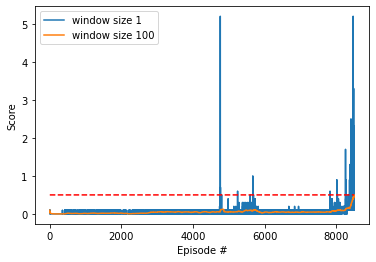

In [69]:
scores = np.array(scores)
scores_window = [np.mean(scores[max(0,i-100):i+1]) for i in range(len(scores))]

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="window size 1")
plt.plot(np.arange(1, len(scores)+1), scores_window, label="window size 100")
plt.plot(np.arange(1, len(scores)+1), [0.5]*len(scores), 
         linestyle='--', color='red')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [97]:
saved_model_agent0_actor = {
    'num_agents': num_agents,
    'state_size': state_size,
    'action_size': action_size,
    'fc1_units': 512,
    'fc2_units': 256,
    'fc3_units': 128,
    'state_dict': agents[0].actor_local.state_dict(),
}

torch.save(saved_model_agent0_actor, './models/saved_model_agent0_actor.pth')

In [98]:
saved_model_agent0_critic = {
    'num_agents': num_agents,
    'state_size': state_size,
    'action_size': action_size,
    'fc1_units': 512,
    'fc2_units': 256,
    'fc3_units': 128,
    'state_dict': agents[0].critic_local.state_dict(),
}

torch.save(saved_model_agent0_critic, './models/saved_model_agent0_critic.pth')

In [99]:
saved_model_agent1_actor = {
    'num_agents': num_agents,
    'state_size': state_size,
    'action_size': action_size,
    'fc1_units': 512,
    'fc2_units': 256,
    'fc3_units': 128,
    'state_dict': agents[1].actor_local.state_dict(),
}

torch.save(saved_model_agent1_actor, './models/saved_model_agent1_actor.pth')

In [100]:
saved_model_agent1_critic = {
    'num_agents': num_agents,
    'state_size': state_size,
    'action_size': action_size,
    'fc1_units': 512,
    'fc2_units': 256,
    'fc3_units': 128,
    'state_dict': agents[1].critic_local.state_dict(),
}

torch.save(saved_model_agent1_critic, './models/saved_model_agent1_critic.pth')

In [101]:

#env.close()

In [102]:
def load_saved_model_actor(filepath, device):
    saved_model = torch.load(filepath)
    actor = Actor(num_agents=saved_model['num_agents'], 
                  state_size=saved_model['state_size'], 
                  action_size=saved_model['action_size'], 
                  seed=SEED, 
                  fc1_units=saved_model['fc1_units'], 
                  fc2_units=saved_model['fc2_units'],
                  fc3_units=saved_model['fc3_units'],).to(device)
    actor.load_state_dict(saved_model['state_dict'])
    
    return actor

In [103]:
def load_saved_model_critic(filepath, device):
    saved_model = torch.load(filepath)
    critic = Critic(num_agents=saved_model['num_agents'], 
                    state_size=saved_model['state_size'], 
                    action_size=saved_model['action_size'], 
                    seed=SEED, 
                    fc1_units=saved_model['fc1_units'], 
                    fc2_units=saved_model['fc2_units'], 
                    fc3_units=saved_model['fc3_units'],).to(device)
    critic.load_state_dict(saved_model['state_dict'])
    
    return critic

In [104]:
agent0_actor_local = load_saved_model_actor('./models/saved_model_agent0_actor.pth',device)
print("agent0_actor_local\n",agent0_actor_local.eval())
agent0_actor_target = load_saved_model_actor('./models/saved_model_agent0_actor.pth',device)
print("agent0_actor_target\n",agent0_actor_target.eval())
agent0_critic_local = load_saved_model_critic('./models/saved_model_agent0_critic.pth',device)
print("agent0_critic_local\n",agent0_critic_local.eval())
agent0_critic_target = load_saved_model_critic('./models/saved_model_agent0_critic.pth', device)
print("agent0_critic_target\n",agent0_critic_target.eval())
agent1_actor_local = load_saved_model_actor('./models/saved_model_agent1_actor.pth',device)
print("agent1_actor_local\n",agent1_actor_local.eval())
agent1_actor_target = load_saved_model_actor('./models/saved_model_agent1_actor.pth', device)
print("agent1_actor_target\n",agent1_actor_target.eval())
agent1_critic_local = load_saved_model_critic('./models/saved_model_agent1_critic.pth',device)
print("agent1_critic_local\n",agent1_critic_local.eval())
agent1_critic_target = load_saved_model_critic('./models/saved_model_agent1_critic.pth', device)
print("agent1_critic_target\n",agent1_critic_target.eval())

agent0_actor_local
 Actor(
  (fc1): Linear(in_features=24, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
agent0_actor_target
 Actor(
  (fc1): Linear(in_features=24, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
agent0_critic_local
 Critic(
  (fc1): Linear(in_features=48, out_features=512, bias=True)
  (fc2): Linear(in_features=516, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=Tru

In [105]:
agents = [Agent(index=0, num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=SEED, device=device),
          Agent(index=1, num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=SEED, device=device),]

In [106]:
agents[0].actor_local = agent0_actor_local
agents[0].actor_target = agent0_actor_target
agents[0].critic_local = agent0_critic_local
agents[0].critic_target = agent0_critic_target
agents[1].actor_local = agent1_actor_local
agents[1].actor_target = agent1_actor_target
agents[1].critic_local = agent1_critic_local
agents[1].critic_target = agent1_critic_target

In [107]:
#env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

In [110]:
for i in range(1, 7):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions0 = agents[0].act(states[0].reshape(1, -1), add_noise=True)
        actions0 = np.clip(actions0, -1, 1)                # all actions between -1 and 1
        actions1 = agents[1].act(states[1].reshape(1, -1), add_noise=True)
        actions1 = np.clip(actions1, -1, 1)                # all actions between -1 and 1
        actions = np.hstack([actions0, actions1])
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        time.sleep(0.1)
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.2900000065565109
Score (max over agents) from episode 2: 0.10000000149011612
Score (max over agents) from episode 3: 0.09000000171363354
Score (max over agents) from episode 4: 0.6000000089406967
Score (max over agents) from episode 5: 0.09000000171363354
Score (max over agents) from episode 6: 0.09000000171363354


In [111]:
pip freeze

absl-py==0.11.0
argon2-cffi @ file:///D:/bld/argon2-cffi_1605217285838/work
astor==0.8.1
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
backcall==0.2.0
backports.functools-lru-cache==1.6.1
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1600454382015/work
certifi==2020.12.5
cffi @ file:///D:/bld/cffi_1606601414542/work
cloudpickle==1.6.0
colorama==0.4.4
cycler==0.10.0
dataclasses==0.7
decorator==4.4.2Note: you may need to restart the kernel to use updated packages.

defusedxml==0.6.0
docopt==0.6.2
EasyProcess==0.3
entrypoints @ file:///home/conda/feedstock_root/build_artifacts/entrypoints_1605121927639/work/dist/entrypoints-0.3-py2.py3-none-any.whl
future==0.18.2
gast==0.4.0
grpcio==1.11.0
gym==0.18.0
html5lib==0.9999999
importlib-metadata @ file:///D:/bld/importlib-metadata_1610123000973/work
iniconfig==1.1.1
ipykernel==5.4.2
ipython==7.16.1
ipython-genutils==0.2.0
ipywidget